In [1]:
from a_mps import *
from b_model import *
from d_dmrg import *
from tfi_exact import finite_gs_energy

import matplotlib.pyplot as plt

import pickle as pkl

In [2]:
def save(filename, dict):
    with open(filename, 'wb') as f:
        pkl.dump(dict, f)

def load(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

**(b)**

In [3]:
L, J, g = 14, 1, 1.5

ψ = init_spinup_MPS(L)
model = TFIModel(L, J, g)
dmrg = DMRGEngine(ψ, model)
gs_energy = finite_gs_energy(L, J, g)

for _ in range(5):
    dmrg.sweep()
    print(gs_energy - model.energy(ψ))

0.002022333896885442
8.199428691568755e-09
3.552713678800501e-15
-3.552713678800501e-15
3.552713678800501e-15


**(c)**

In [4]:
def dmrg_sim(L, J, g):

    ψ = init_spinup_MPS(L)
    model = TFIModel(L, J, g)
    dmrg = DMRGEngine(ψ, model)

    E = model.energy(ψ)
    ΔE = 1
    while ΔE >= 1e-10:

        dmrg.sweep()
        E_next = model.energy(ψ)
        ΔE = abs(E - E_next)
        E = E_next
    
    return model, ψ

**(d)**

In [5]:
def compute_S_half(Ls, J, gs):

    S = dict()
    for g in gs:

        S[g] = list()
        for L in Ls:

            _, ψ = dmrg_sim(L, J, g)
            S[g].append(ψ.entanglement_entropy()[L//2])

    S['Ls'], S['J'], S['gs'] = Ls, J, gs

    return S

In [6]:
Ls = [8, 16, 32, 64, 96, 128]
J = 1
gs = [1.5, 1.0, 0.5]

S = compute_S_half(Ls, J, gs)

filename = 'exercise10_data/S.pkl'
save(filename, S)

In [7]:
filename = 'exercise10_data/S.pkl'
S = load(filename)
Ls, J, gs = S['Ls'], S['J'], S['gs']

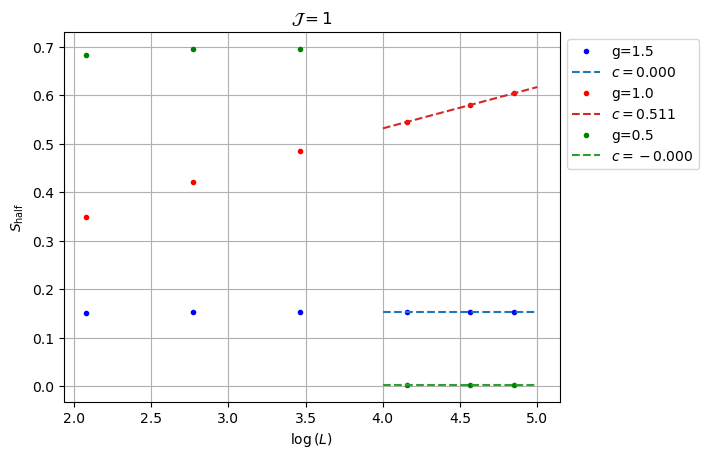

In [8]:
fig, ax = plt.subplots(1, 1)
colors = {0.5: ['tab:green', 'green'], 1.0: ['tab:red', 'red'], 1.5: ['tab:blue', 'blue']}
for g in gs:

    ax.plot(np.log(Ls), S[g], '.', label='g=%.1f'%(g), color=colors[g][1])

    coeff = np.polyfit(np.log(Ls)[-3:], S[g][-3:], deg=1)
    c = coeff[0]*6
    fit = np.poly1d(coeff)
    l = np.linspace(4, 5, 100)
    ax.plot(l, fit(l), '--', label='$c=%.3f$'%(c), color=colors[g][0])

ax.set_xlabel('$\log{(L)}$'), ax.set_ylabel('$S_{\mathrm{half}}$'), ax.set_title('$\mathcal{J}=%d$'%(J)), ax.grid(), ax.legend(bbox_to_anchor=(1.0, 1.0));

**(e)**

In [9]:
def correlations(mps, X, Y, i):

    c_list = list()

    # case j=i
    t = np.tensordot(X@Y, mps.get_theta1(i), [1, 1])  # i* [i], vL [i] vR
    c = np.tensordot(mps.get_theta1(i).conj(), t, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i*] [vL] [vR]
    c_list.append(c)

    # case j>i
    if i < mps.L - 1:
        t = np.tensordot(X, mps.get_theta1(i), [1, 1]) # i* [i], vL [i] vR
        t = np.tensordot(t, mps.get_theta1(i), [[0, 1], [1, 0]]) # [i*] [vL] vR, [vL*] [i*] vR*
        for j in range(i + 1, mps.L):

            t = np.tensordot(t, mps.Bs[j], [0, 0]) # [vR] vR*, [vL] j vR

            t_copy = t.copy()
            t_copy = np.tensordot(t_copy, Y, [1, 1]) # vR* [j] vR, j* [j]
            c = np.tensordot(t_copy, mps.Bs[j], [[0, 1, 2], [0, 2, 1]]) # [vR*] [vR] [j*], [vL*] [j*] [vR*]
            c_list.append(c)
            del t_copy

            t = np.tensordot(t, mps.Bs[j].conj(), [[0, 1], [0, 1]]) # [vR*] [j] vR, [vL*] [j*] vR*

    return c_list

**(f) + (g)**

In [10]:
L = 100
J = 1
gs = [0.5, 1., 1.1, 1.2, 1.5]

states = dict()
for g in gs:
    _, ψ = dmrg_sim(L, J, g)
    states[g] = ψ
states['meta'] = {'L':L, 'J':J, 'gs':gs}

filename = 'exercise10_data/states.pkl'
save(filename, states)

In [11]:
states = load('exercise10_data/states.pkl')
L, J, gs = states['meta'].values()
sigma_x = np.array([[0, 1],[1, 0]])

C, XX = list(), list()
for g in gs:
    
    ψ = states[g]
    xx = correlations(ψ, sigma_x, sigma_x, L//4 - 1)
    XX.append(xx)
    
    x = ψ.site_expectation_value(sigma_x)
    c = xx - x[L//4 - 1] * x[(L//4 - 1):]
    C.append(c)

C, XX = np.array(C), np.array(XX)

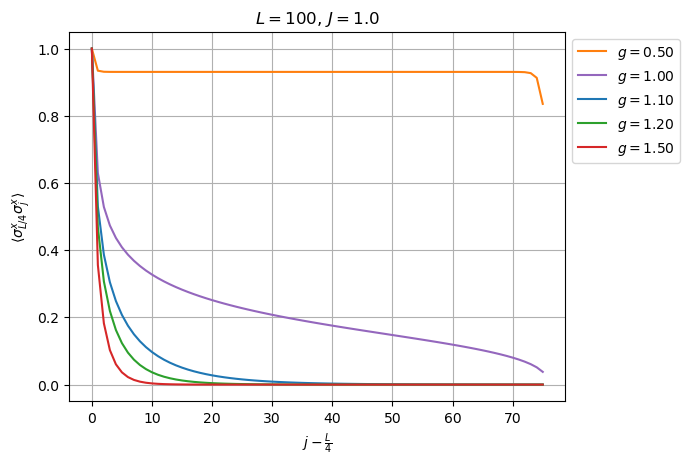

In [30]:
fig, ax = plt.subplots(1, 1)
colors = {0.5: ['tab:orange', 'orange'], 1.0: ['tab:purple', 'purple'], 1.1: ['tab:blue', 'blue'], 1.2: ['tab:green', 'green'], 1.5: ['tab:red', 'red']}
for (i, g) in enumerate(gs):
    ax.plot(XX[i], '-', label='$g=%.2f$'%(g), color=colors[g][0])
ax.set_xlabel('$j - \\frac{L}{4}$'), ax.set_ylabel('$\langle\sigma^x_{L/4} \sigma^x_j \\rangle$'), ax.set_title('$L=%d$, $J=%.1f$'%(L, J)), ax.grid(), ax.legend(bbox_to_anchor=(1.0, 1.0));

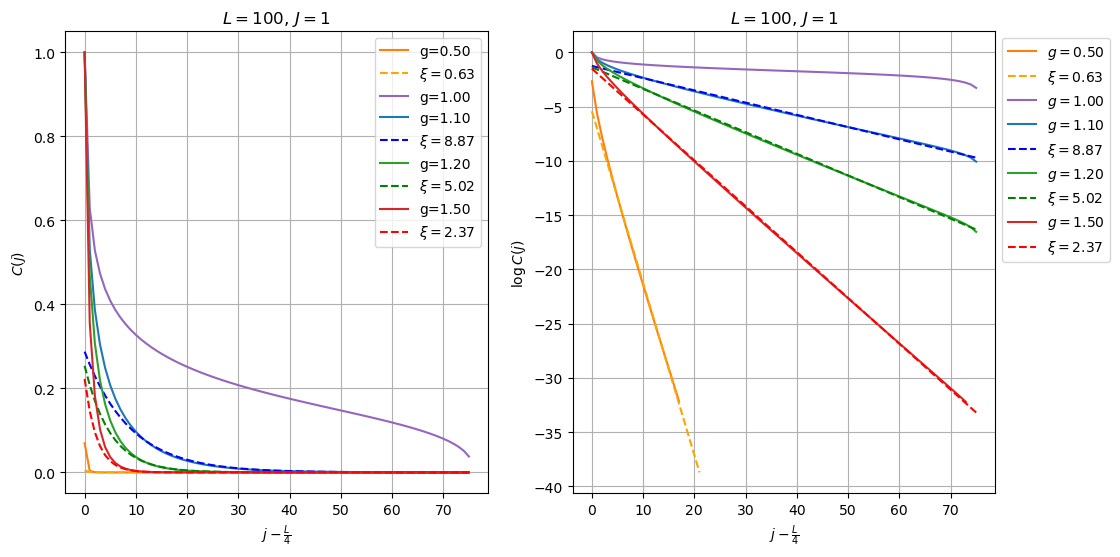

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
colors = {0.5: ['tab:orange', 'orange'], 1.0: ['tab:purple', 'purple'], 1.1: ['tab:blue', 'blue'], 1.2: ['tab:green', 'green'], 1.5: ['tab:red', 'red']}
for (i, g) in enumerate(gs):

    ax0.plot(C[i], '-', label='g=%.2f'%(g), color=colors[g][0])

    filter = (C[i] >= 1e-14)
    ax1.plot(np.log(C[i][filter]), '-', label='$g=%.2f$'%(g), color=colors[g][0])

    if g != 1.0:
        dist = np.arange(0, 3*L//4 + 1, 1)
        filter = filter & ((dist>2) & (dist<L-2))
        coeff = np.polyfit(dist[filter], np.log(C[i][filter]), deg=1)
        ξ = -1 / coeff[0]
        fit = np.poly1d(coeff)

        ax0.plot(dist, np.exp(fit(dist)), '--', label='$\\xi=%.2f$'%(ξ), color=colors[g][1])
        filter_ = fit(dist)>=-40
        ax1.plot(dist[filter_], fit(dist)[filter_], '--', label='$\\xi=%.2f$'%(ξ), color=colors[g][1])

ax0.set_xlabel('$j - \\frac{L}{4}$'), ax0.set_ylabel('$C(j)$'), ax0.set_title('$L=%d$, $J=%d$'%(L, J)), ax0.grid(), ax0.legend(bbox_to_anchor=(1.0, 1.0));
ax1.set_xlabel('$j - \\frac{L}{4}$'), ax1.set_ylabel('$\log{C(j)}$'), ax1.set_title('$L=%d$, $J=%d$'%(L, J)), ax1.grid(), ax1.legend(bbox_to_anchor=(1.0, 1.0));

In [14]:
def inner_product(mps_a: list, mps_b: list):

    L = mps_a.L
    assert L == mps_b.L

    t = np.tensordot(mps_b.Bs[0], mps_a.Bs[0].conj(), axes=[1, 1]) # vL [j] vR, vL* [j*] vR*
    t = t.squeeze(axis=(0, 2))  # vR vR*

    for n in range(1, L):

        t = np.tensordot(t, mps_b.Bs[n], axes=[0, 0]) # [vR] vR*, [vL] j vR
        t = np.tensordot(t, mps_a.Bs[n].conj(), axes=[[0, 1], [0, 1]]) # [vR*] [j] vR, [vL*] [j*] vR*

    return t.item() 

In [16]:
def init_spinleft_MPS(L):
    """Return a product state with all spins right as an MPS"""
    B = np.zeros([1, 2, 1], float)
    B[0, 0, 0] = 1/np.sqrt(2)
    B[0, 1, 0] = -1/np.sqrt(2)
    S = np.ones([1], float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return MPS(Bs, Ss)

def init_spinright_MPS(L):
    """Return a product state with all spins right as an MPS"""
    B = np.zeros([1, 2, 1], float)
    B[0, 0, 0] = B[0, 1, 0] = 1/np.sqrt(2)
    S = np.ones([1], float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return MPS(Bs, Ss)


mps_spinleft, mps_spinright = init_spinleft_MPS(L), init_spinright_MPS(L)
assert np.isclose(0, inner_product(mps_spinright, mps_spinleft))
inner_product(states[0.5], mps_spinleft), inner_product(states[0.5], mps_spinright)

(0.40755791845170003, 9.479144669693567e-32)